# CHARACTERISING THE RSA-BASED DEFINED CLUSTERS

## IMPORTING NECESSARY PACKAGES

In [1]:
from fragsys_analysis import *

## READING INPUT DATA

In [2]:
main_dir = "."
results_dir = os.path.join(main_dir, "results/new")
figs_dir = os.path.join(main_dir, "figs")

In [3]:
rsa_cluster_dict = load_pickle(os.path.join(results_dir, "rsa_cluster_dict.pkl"))
cluster_membership = load_pickle(os.path.join(results_dir, "rsa_cluster_membership.pkl"))
rsa_profs = load_pickle(os.path.join(results_dir, "rsa_profs.pkl"))
all_bs_ress = pd.read_pickle(os.path.join(results_dir, "all_bs_ress.pkl"))

In [4]:
print(len(all_bs_ress)) # number of ligand binding residues
print(len(all_bs_ress.drop_duplicates(["protein", "UniProt_ResNum", "UniProt_ResName"]))) # number of unique ligand binding residues
print(len(cluster_membership)) # number of ligand binding sites with RSA profile and cluster label

14172
2664
4


In [5]:
c_labs = list(rsa_cluster_dict.values())
un_c_labs = list(set(c_labs))
for lab in list(set(c_labs)):
    print(lab, c_labs.count(lab))

0 46
1 127
2 91
3 29


## GETTING FEATURES FOR EACH CLUSTER

In [8]:
ex_dict = {un_c_lab: [] for un_c_lab in un_c_labs}
aa_dict, mes_dict, shenk_dict, rsa_dict = [copy.deepcopy(ex_dict), copy.deepcopy(ex_dict), copy.deepcopy(ex_dict), copy.deepcopy(ex_dict)]

all_bs_ress.group = all_bs_ress.group.astype(str)

for bs_id, bs_c_lab in rsa_cluster_dict.items():
    bs_prot, bs_group, bs_n = bs_id.split("_")
    bs_ress = all_bs_ress.query("protein == @bs_prot & group == @bs_group & {0} == 1".format(bs_n))
    bs_ress = bs_ress.drop_duplicates(["protein", "UniProt_ResNum", "UniProt_ResName"])
    aa_dict[bs_c_lab].extend(bs_ress.AA.tolist())
    mes_dict[bs_c_lab].extend(bs_ress.query('occ >= 25 and occ_pct >= 0.50 & human_occ > 10 & human_occ_pct > 0.50 & variants >= 2').log_oddsratio.tolist())
    shenk_dict[bs_c_lab].extend(bs_ress.query('occ >= 20 and occ_pct >= 0.50').abs_norm_shenkin.tolist())
    bs_ress["RSA"] = bs_ress["RSA"].apply(lambda x: x if x <= 100 else 100)
    rsa_dict[bs_c_lab].extend(bs_ress.RSA.tolist())

In [9]:
order = [0, 1, 2, 3]
my_pal = {i: sample_colors[i] for i in order}

## RELATIVE SOLVENT ACCESSIBILITY

In [10]:
rsa_values = []
cluster_values = []
for k, v in rsa_dict.items():
    rsa_values.extend(v)
    cluster_values.extend([k for i in range(len(v))])
rsa_df = pd.DataFrame(list(zip(rsa_values, cluster_values)), columns = ["RSA", "Cluster"])

In [11]:
rsa_df.Cluster.value_counts().sort_index()

0     718
1    1459
2     776
3     145
Name: Cluster, dtype: int64

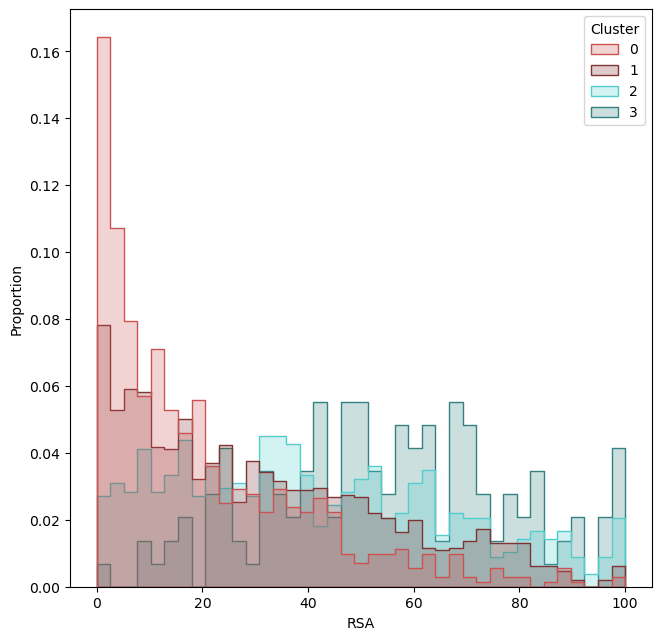

In [14]:
plt.figure(figsize = (7.5, 7.5), dpi = 100)
plt.xlabel("RSA")
rsa_bns = np.linspace(0, 100, 40)
sns.histplot(
    data = rsa_df.query('RSA <= 100'), x = "RSA", hue = "Cluster", palette = my_pal,
    common_norm = False, fill = True, stat = "proportion", element = "step", bins = rsa_bns
)
plt.ylim(0,)
#plt.savefig(os.path.join(figs_dir, "RSA_clusters_rsa.png"))
plt.show()

In [15]:
order = [0, 1, 2, 3]
pairs = [(0, 1),(0,2), (0,3), (1, 2), (1, 3), (2,3)]
flierprops = dict(marker = "o", markerfacecolor = "black", markersize = 4,
                  markeredgecolor = "none")

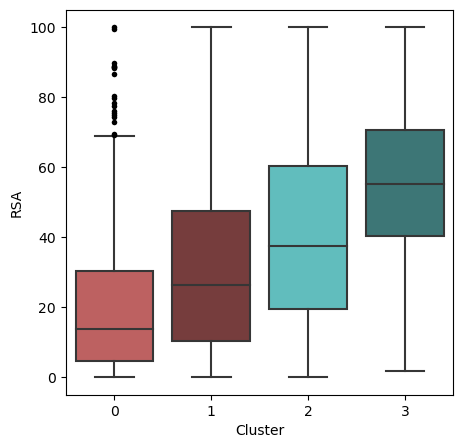

In [13]:
plot_boxes(
    rsa_df, "Cluster", "RSA", order, pairs, my_pal, flierprops,
    fsize = (5, 5), dpi = 100, annotate = False, ann_loc = "inside",
    out = False, show = True
)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:9.387e-21 U_stat=1.353e+05
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.675e-21 U_stat=6.103e+05
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:1.323e-10 U_stat=7.600e+04
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:2.875e-44 U_stat=5.485e+04
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:9.066e-32 U_stat=9.071e+04
0 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:3.563e-49 U_stat=6.169e+03


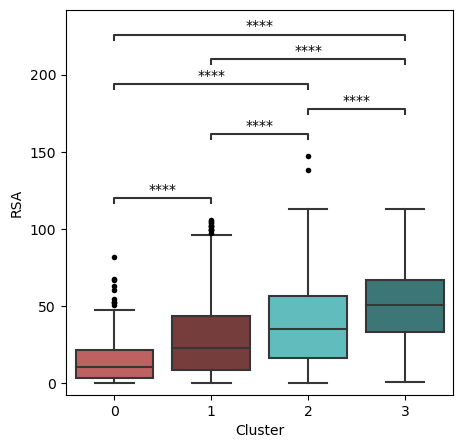

In [36]:
plot_boxes(
    rsa_df, "Cluster", "RSA", order, pairs, my_pal,
    fsize = (5, 5), dpi = 100, annotate = True, ann_loc = "inside",
    out = False, show = True
)

## NORMALISED SHENKIN DIVERGENCE SCORE

In [16]:
shenk_values = []
cluster_values = []
for k, v in shenk_dict.items():
    shenk_values.extend(v)
    cluster_values.extend([k for i in range(len(v))])
shenk_df = pd.DataFrame(list(zip(shenk_values, cluster_values)), columns = ["Shenkin", "Cluster"])

In [17]:
shenk_df.Cluster.value_counts().sort_index()

0    452
1    900
2    451
3     68
Name: Cluster, dtype: int64

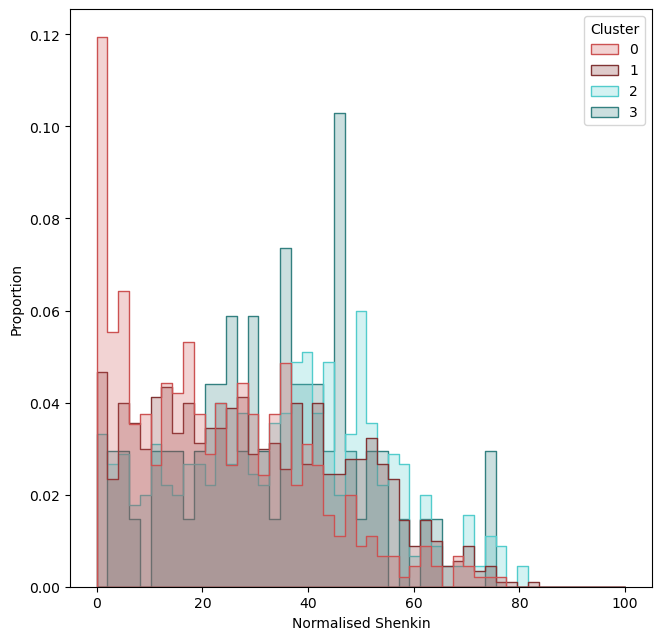

In [19]:
plt.figure(figsize = (7.5, 7.5), dpi = 100)
plt.xlabel("Normalised Shenkin")
snk_bns = np.linspace(0,100,50)
sns.histplot(data = shenk_df, x = "Shenkin", hue = "Cluster", palette = my_pal, common_norm = False,
            fill = True, stat = "proportion", element = "step", bins = snk_bns)
plt.ylim(0,)
#plt.savefig(os.path.join(figs_dir, "RSA_clusters_shenk.png"))
plt.show()

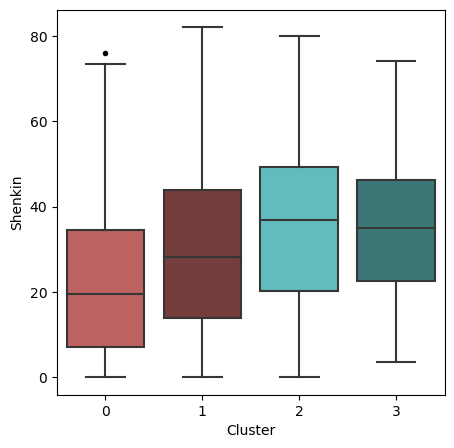

In [17]:
plot_boxes(
    shenk_df, "Cluster", "Shenkin", order, pairs, my_pal, flierprops,
    fsize = (5, 5), dpi = 100, annotate = False, ann_loc = "inside",
    out = False, show = True
)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:4.026e-11 U_stat=5.849e+04
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:6.331e-05 U_stat=2.454e+05
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:3.166e-03 U_stat=2.186e+04
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:3.526e-17 U_stat=2.510e+04
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:2.636e-07 U_stat=3.588e+04
0 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:3.855e-17 U_stat=3.159e+03


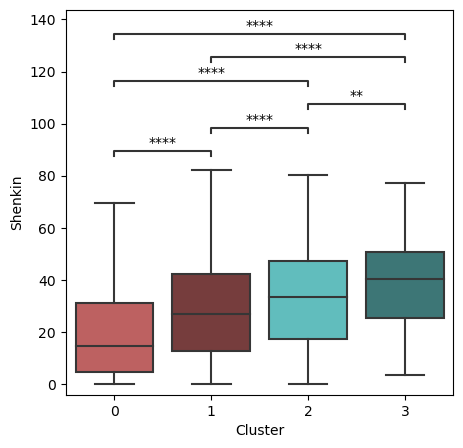

In [48]:
plot_boxes(
    shenk_df, "Cluster", "Shenkin", order, pairs, my_pal,
    fsize = (5, 5), dpi = 100, annotate = True, ann_loc = "inside",
    out = False, show = True
)

# MISSENSE ENRICHMENT SCORE

In [20]:
mess_values = []
cluster_values = []
for k, v in mes_dict.items():
    mess_values.extend(v)
    cluster_values.extend([k for i in range(len(v))])
    
mess_df = pd.DataFrame(list(zip(mess_values, cluster_values)), columns = ["MES", "Cluster"])

In [21]:
mess_df.Cluster.value_counts().sort_index()

0    296
1    653
2    386
3     53
Name: Cluster, dtype: int64

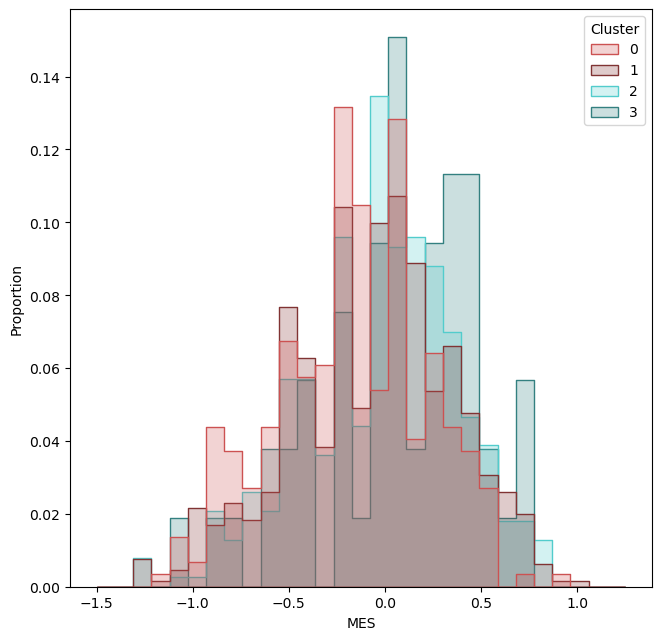

In [23]:
mes_bns = np.linspace(-1.5,1.25, 30)
plt.figure(figsize = (7.5, 7.5), dpi = 100)
plt.xlabel("MES")
sns.histplot(data = mess_df, x = "MES", hue = "Cluster", palette = my_pal, common_norm = False, fill = True, stat = "proportion", element = "step", bins = mes_bns)
plt.ylim(0,)
#plt.savefig(os.path.join(figs_dir, "RSA_clusters_mes.png"))
plt.show()

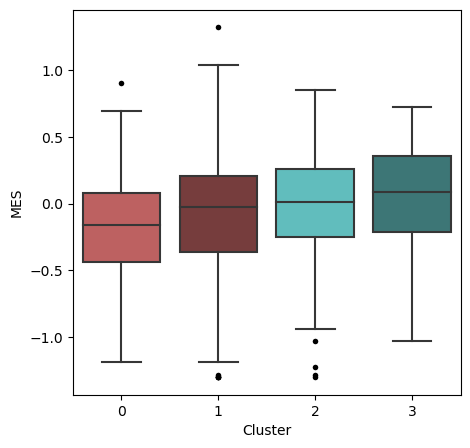

In [21]:
plot_boxes(
    mess_df, "Cluster", "MES", order, pairs, my_pal, flierprops,
    fsize = (5, 5), dpi = 100, annotate = False, ann_loc = "inside",
    out = False, show = True
)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:3.581e-02 U_stat=2.694e+04
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:2.142e-03 U_stat=1.501e+05
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:3.869e-01 U_stat=1.543e+04
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:6.384e-04 U_stat=1.373e+04
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:1.225e-02 U_stat=2.366e+04
0 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:1.254e-03 U_stat=2.156e+03


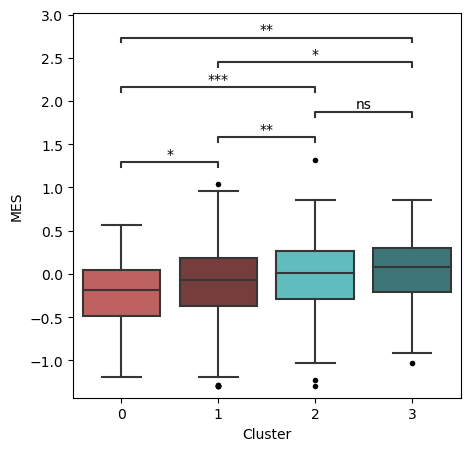

In [47]:
plot_boxes(
    mess_df, "Cluster", "MES", order, pairs, my_pal,
    fsize = (5, 5), dpi = 100, annotate = True, ann_loc = "inside",
    out = False, show = True
)

### CALCULATING CLUSTER BURIAL PROPORTION AND SITE SIZES

In [22]:
burial_props, lens, cluster_labs = [[], [], []]
ut_dict, len_dict, bs_size_dict = [{}, {}, {}]
for k, v in cluster_membership.items():
    ut_dict[k] = []
    len_dict[k] = []
    for lab in v:
        vals = rsa_profs[lab]
        ut = len([v for v in vals if v <= 25])
        burial_prop = ut/len(vals)
        ut_dict[k].append(burial_prop)
        burial_props.append(burial_prop)
        len_dict[k].append(len(vals))
        bs_size_dict[lab] = len(vals)
        lens.append(len(vals))
        cluster_labs.append(k)
    
for i in range(len(cluster_membership.keys())):
    print(i, round(statistics.mean(ut_dict[i]),2), statistics.median(len_dict[i]))

0 0.68 14.5
1 0.47 10
2 0.3 8
3 0.1 5


In [24]:
prop_burial_vs_size = pd.DataFrame(list(zip(cluster_labs, burial_props, lens)), columns = ['cluster_id', 'prop_burial', 'bs_size'])

In [25]:
prop_burial_vs_size.head(3)

,cluster_id,prop_burial,bs_size
0,0,0.666667,24
1,0,1.000000,6
2,0,0.666667,12


### BINDING SITE SIZE (AA)

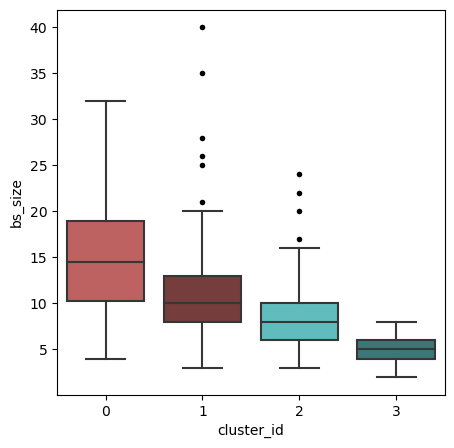

In [26]:
plot_boxes(
    prop_burial_vs_size, "cluster_id", "bs_size", order, pairs, my_pal, flierprops,
    fsize = (5, 5), dpi = 100, annotate = False, ann_loc = "inside",
    out = False, show = True
)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:5.921e-01 U_stat=1.176e+03
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:6.412e-04 U_stat=8.310e+03
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:1.528e-10 U_stat=3.400e+03
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:3.383e-02 U_stat=1.156e+03
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:7.215e-12 U_stat=4.304e+03
0 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:4.136e-05 U_stat=5.605e+02


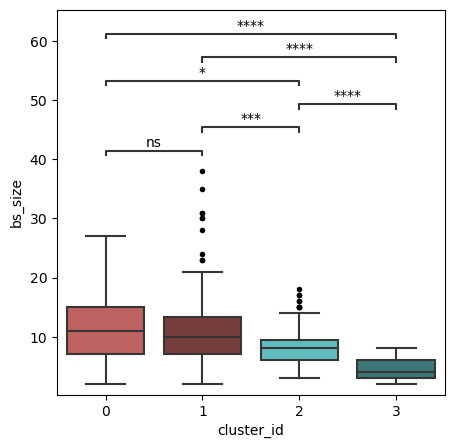

In [38]:
plot_boxes(
    prop_burial_vs_size, "cluster_id", "bs_size", order, pairs, my_pal,
    fsize = (5, 5), dpi = 100, annotate = True, ann_loc = "inside",
    out = False, show = True
)

### PROPORTION OF BURIED RESIDUES (RSA < 25)

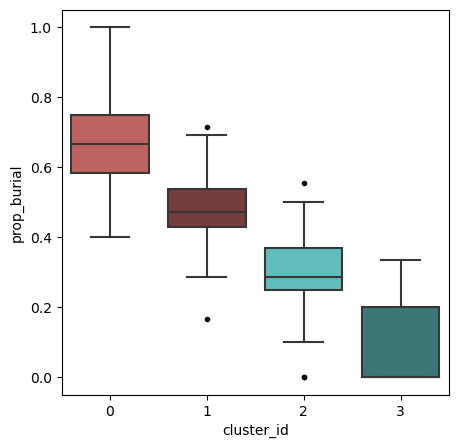

In [27]:
plot_boxes(
    prop_burial_vs_size, "cluster_id", "prop_burial", order, pairs, my_pal, flierprops,
    fsize = (5, 5), dpi = 100, annotate = False, ann_loc = "inside",
    out = False, show = True
)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.138e-10 U_stat=2.131e+03
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.628e-22 U_stat=1.150e+04
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:6.115e-16 U_stat=3.770e+03
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:4.021e-11 U_stat=1.751e+03
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:7.277e-21 U_stat=4.960e+03
0 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:1.126e-09 U_stat=6.630e+02


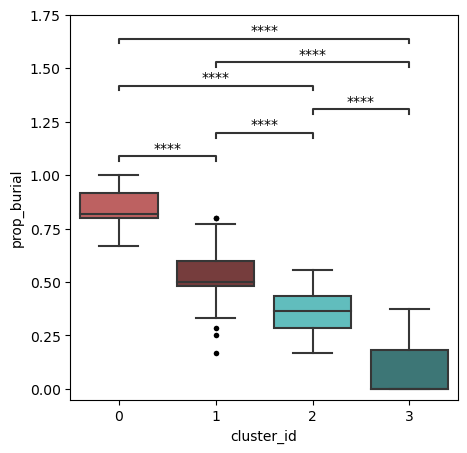

In [37]:
plot_boxes(
    prop_burial_vs_size, "cluster_id", "prop_burial", order, pairs, my_pal,
    fsize = (5, 5), dpi = 100, annotate = True, ann_loc = "inside",
    out = False, show = True
)